**Task:**

Create a DL training pipeline to train a LSTM/GRU (any one) and one Transformers
network to identify Sentiments in a sentence. You are free to choose any open
source dataset (like IMDB reviews or Amazon product ratings or any other). Report
your accuracy. Create an inference pipeline which can accept a user text and provide
score to each sentiment on it.**bold text**

1. LSTM approach

In [ ]:
# module installation
!pip install 'portalocker>=2.8.2' # for data_iter_downloading

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchtext
from torchtext.datasets import IMDB
from torchtext.data import get_tokenizer

import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)
print(torchtext.__version__)

2.2.1+cu121
0.17.1+cpu


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# device = torch.device('cpu')

device(type='cuda')

In [ ]:
train_data_iter, test_data_iter = IMDB(split=('train', 'test'))

In [ ]:
import pandas as pd
def get_dataframe(iterator=train_data_iter):
  labels, reviews = [], []
  for label, line in iterator:
      labels.append(label)
      reviews.append(line)
  df = pd.DataFrame({'sentiment': labels, 'review': reviews})
  return df


In [ ]:
df_train = get_dataframe(train_data_iter)
print(df_train.shape)
df_test = get_dataframe(test_data_iter)
print(df_test.shape)

(25000, 2)
(25000, 2)


In [ ]:
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

sentiment
1    12500
2    12500
Name: count, dtype: int64
sentiment
1    12500
2    12500
Name: count, dtype: int64


In [ ]:

df_train = df_train.sample(frac=1).reset_index(drop=True)


In [ ]:
import re
def clean_text(text):
  # removing html tags that contains at max 10 character, incase someone wrote review in the brackets.
  text = re.sub(r"<[^>]{1,10}>", " ", text)

  #removing all not alphabet charaters
  text = re.sub(r"[^A-Za-z .,']", " ", text)

  # removing mulitple spaces
  text = re.sub(r"\s+", " ", text)

  return text.strip(" ").strip(".").lower()

# to be applied to all the texts before proceeding to model training

In [ ]:
df_train['review'] = df_train['review'].apply(clean_text)
df_test['review'] = df_test['review'].apply(clean_text)

df_train['sentiment'] = df_train['sentiment'] - 1
df_test['sentiment'] = df_test['sentiment'] -1

In [ ]:
VOCAB_SIZE = 20000

In [ ]:
train_data_iter = [(row['sentiment'], row['review']) for _, row in df_train.iterrows()]
test_data_iter = [(row['sentiment'], row['review']) for _, row in df_test.iterrows()]


In [ ]:
#building vocabolary
tokenizer = get_tokenizer('basic_english')
from torchtext.vocab import build_vocab_from_iterator, Vocab, vocab

from collections import Counter

counter = Counter()
for _, text in train_data_iter:
    tokens = tokenizer(text)
    counter.update(tokens)

most_common = counter.most_common(VOCAB_SIZE)
most_common = {f'{key[0]}': key[1] for key in most_common}

vocab = vocab(Counter(most_common), specials=["<unk>", "<pad>"])


In [ ]:
train_dataloader = DataLoader(train_data_iter, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data_iter, batch_size=32, shuffle=False)


In [ ]:
class sentimentModelvLSTM(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim=1):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, embedding_dim)
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
    self.fc2 = nn.Linear(hidden_dim//2, output_dim)
    self.sigmoid = nn.Sigmoid()
    for name, param in self.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param, mean=0.0, std=0.01)

  def forward(self, review):
    embed = self.embedding(review.long())

    embed = embed.permute(1,0,2)

    h0 = torch.zeros(1, embed.size(1), self.hidden_dim).to(embed.device)
    c0 = torch.zeros(1, embed.size(1), self.hidden_dim).to(embed.device)
    output, (hn, cn) = self.lstm(embed, (h0, c0))

    hn = hn.squeeze(0)
    fc_layer = self.fc1(hn)
    out = self.fc2(fc_layer)
    out_final = self.sigmoid(out)
    return out_final.squeeze(1)



In [ ]:
LSTMmodel = sentimentModelvLSTM(
    input_dim = len(vocab),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=1
).to(device)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=LSTMmodel.parameters(),
                             lr = 0.0001)

In [ ]:
def accuracy_calculation(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def pad_sequences(sequences, max_length=50, padding_value=1):

    lengths = [min(len(seq), max_length) for seq in sequences]
    padded_sequences = torch.full((len(sequences), max_length), padding_value, dtype=torch.long)
    for i, seq in enumerate(sequences):
        end = min(len(seq), max_length)
        padded_sequences[i, :end] = torch.tensor(seq[:end])
    return padded_sequences, lengths


In [ ]:
# df_train['review'].apply(lambda x: len(tokenizer(x))).mean()

In [ ]:
# training the model
epochs = 15
torch.manual_seed(42)
from tqdm import tqdm
epochs_list = []
training_loss_list = []
test_loss_list = []
test_acc_list = []

for epoch in tqdm(range(epochs)):
  print(f"Epoch count: {epoch}" )
  train_loss, train_acc = 0, 0
  LSTMmodel.train()
  for idx, batch in enumerate(train_dataloader):
    y, X = batch
    indices = [torch.tensor([vocab[token] if token in vocab else 0 for token in tokenizer(text)]) for text in X]
    X_tensor, lengths = pad_sequences(indices, max_length=250)
    X_tensor = X_tensor.to(device)

    y = y.to(device)
    optimizer.zero_grad()
    y_pred = LSTMmodel(X_tensor)

    loss = loss_fn(y_pred.float(), y.float())
    train_loss += loss

    loss.backward()
    optimizer.step()

  train_loss = train_loss/len(train_dataloader)

  test_loss, test_accuracy = 0, 0
  LSTMmodel.eval()
  with torch.inference_mode():
    for y_test, X_test in test_dataloader:
      indices = [torch.tensor([vocab[token] if token in vocab else 0 for token in tokenizer(text)]) for text in X_test]
      X_test_tensor, lengths = pad_sequences(indices, max_length=250)
      X_test_tensor = X_test_tensor.to(device)
      y_test = y_test.to(device)
      test_pred = LSTMmodel(X_test_tensor)
      t_loss = loss_fn(test_pred.float(), y_test.float())
      test_loss += t_loss

      test_accuracy += accuracy_calculation(test_pred.round(), y_test)
    test_loss = test_loss/len(test_dataloader)
    test_accuracy = test_accuracy/len(test_dataloader)

  epochs_list.append(epoch)
  training_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_accuracy)
  print(f"train_loss: {train_loss: .3f} | test_loss: {test_loss: .3f}, test_accuracy: {test_accuracy: .2f}")



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch count: 0


  7%|▋         | 1/15 [00:27<06:18, 27.04s/it]

train_loss:  0.142 | test_loss:  1.293, test_accuracy:  67.47
Epoch count: 1


 13%|█▎        | 2/15 [00:54<05:54, 27.29s/it]

train_loss:  0.144 | test_loss:  1.311, test_accuracy:  67.70
Epoch count: 2


 20%|██        | 3/15 [01:22<05:30, 27.55s/it]

train_loss:  0.140 | test_loss:  1.327, test_accuracy:  67.85
Epoch count: 3


 27%|██▋       | 4/15 [01:49<05:01, 27.37s/it]

train_loss:  0.142 | test_loss:  1.336, test_accuracy:  68.19
Epoch count: 4


 33%|███▎      | 5/15 [02:16<04:32, 27.25s/it]

train_loss:  0.143 | test_loss:  1.309, test_accuracy:  67.68
Epoch count: 5


 40%|████      | 6/15 [02:43<04:05, 27.32s/it]

train_loss:  0.136 | test_loss:  1.348, test_accuracy:  67.82
Epoch count: 6


 47%|████▋     | 7/15 [03:11<03:39, 27.41s/it]

train_loss:  0.133 | test_loss:  1.373, test_accuracy:  67.65
Epoch count: 7


 53%|█████▎    | 8/15 [03:38<03:11, 27.31s/it]

train_loss:  0.135 | test_loss:  1.362, test_accuracy:  67.63
Epoch count: 8


 60%|██████    | 9/15 [04:05<02:43, 27.23s/it]

train_loss:  0.139 | test_loss:  1.357, test_accuracy:  67.99
Epoch count: 9


 67%|██████▋   | 10/15 [04:33<02:16, 27.37s/it]

train_loss:  0.131 | test_loss:  1.352, test_accuracy:  67.60
Epoch count: 10


 73%|███████▎  | 11/15 [05:00<01:49, 27.36s/it]

train_loss:  0.130 | test_loss:  1.372, test_accuracy:  67.59
Epoch count: 11


 80%|████████  | 12/15 [05:27<01:21, 27.25s/it]

train_loss:  0.127 | test_loss:  1.405, test_accuracy:  67.72
Epoch count: 12


 87%|████████▋ | 13/15 [05:54<00:54, 27.24s/it]

train_loss:  0.125 | test_loss:  1.399, test_accuracy:  67.54
Epoch count: 13


 93%|█████████▎| 14/15 [06:22<00:27, 27.38s/it]

train_loss:  0.124 | test_loss:  1.401, test_accuracy:  67.87
Epoch count: 14


100%|██████████| 15/15 [06:50<00:00, 27.34s/it]

train_loss:  0.126 | test_loss:  1.415, test_accuracy:  67.62


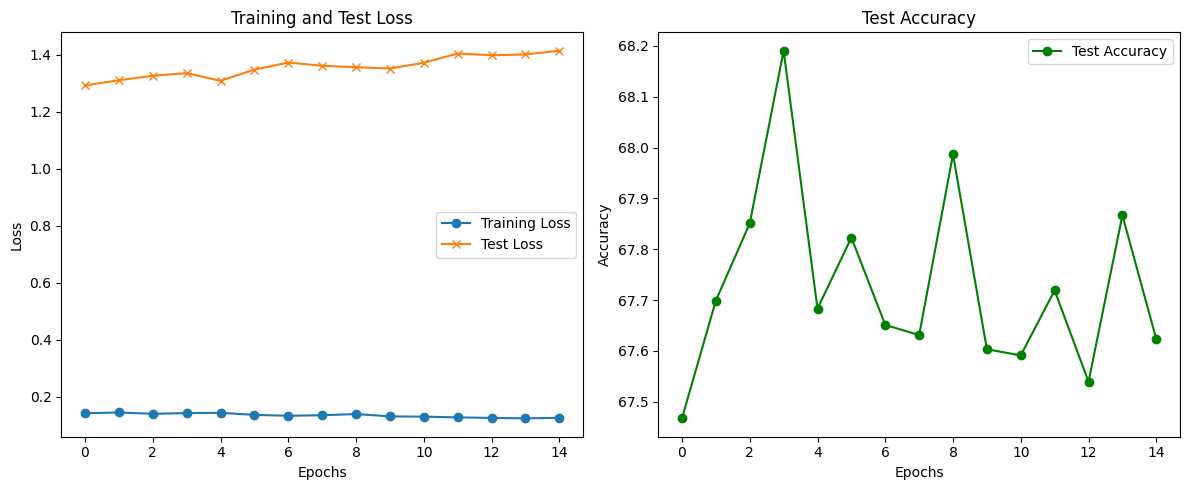

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, [tensor.detach().cpu().numpy() for tensor in training_loss_list] , label='Training Loss', marker='o')
plt.plot(epochs_list, [tensor.detach().cpu().numpy() for tensor in test_loss_list], label='Test Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, test_acc_list, label='Test Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
128*250

32000

In [ ]:
# inference pipeline
# [128, 250] # 5x5


def preprocess_text(input_text, vocab, tokenizer):
    input_text = clean_text(input_text)
    indices = [torch.tensor([vocab[token] if token in vocab else 0 for token in tokenizer(input_text)])]

    return indices

def predict_sentiment(text, model, vocab, tokenizer):
    LSTMmodel.eval()
    with torch.inference_mode():
        indexed = preprocess_text(text, vocab, tokenizer)
        val_tensor, lengths = pad_sequences(indexed, max_length=250)
        prediction = model(val_tensor.to(device))
        print(prediction)
        return prediction.item()

input_text = "worst movie ever"
sentiment = predict_sentiment(input_text, LSTMmodel, vocab, tokenizer)
sentiment_in_word = 'positive' if round(sentiment)==1 else 'Negative'
print("Sentiment:", sentiment_in_word)

tensor([0.0093], device='cuda:0')
Sentiment: Negative
